Input: Infered road volume data
Output : road utilization to (8)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


class CriticalValuesCalculator:
    """
    A class to calculate critical flow (qc) and critical speed (vc) for road segments, and to visualize
    the Q-V diagram for a given road ID.
    """

    def __init__(self, file_path):
        """
        Initializes the CriticalValuesCalculator with the file path to the data.

        Args:
            file_path (str): The path to the input CSV files.
        """
        self.file_path = file_path
        self.scaler = MinMaxScaler()  # Initialize the scaler
        self.level1_road_history_workday = pd.read_csv(self.file_path + 'level1_road_history_workday_profile.csv')
        self.level2_road_history_workday = pd.read_csv(self.file_path + 'level2_road_history_workday_profile.csv')
        self.level3_road_history_workday = pd.read_csv(self.file_path + 'level3_road_history_workday_profile.csv')
        self.level1_road_history_holiday = pd.read_csv(self.file_path + 'level1_road_history_holiday_profile.csv')
        self.level2_road_history_holiday = pd.read_csv(self.file_path + 'level2_road_history_holiday_profile.csv')
        self.level3_road_history_holiday = pd.read_csv(self.file_path + 'level3_road_history_holiday_profile.csv')

        self._initialize_qc_vc()

    def _initialize_qc_vc(self):
        """
        Initializes 'qc' and 'vc' columns with NaN in all dataframes.
        """
        for df in [self.level1_road_history_workday, self.level2_road_history_workday,
                   self.level3_road_history_workday, self.level1_road_history_holiday,
                   self.level2_road_history_holiday, self.level3_road_history_holiday]:
            df['qc'] = np.nan
            df['vc'] = np.nan


    def getQV_1(self, data_df, road_id):
        """
        Calculates the critical flow (Qc) and critical speed (Vc) for a given road ID using K-means clustering.

        Args:
            data_df (pd.DataFrame): The input DataFrame containing road data (avg_speed, volume, road_id).
            road_id (int): The ID of the road segment.

        Returns:
            tuple (float, float): A tuple containing the critical flow (Qc) and critical speed (Vc).
                                  Returns (None, None) if no data is available for the road ID.
        """
        # Filter the data for the specified road ID
        temp_df = data_df[data_df['road_id'] == road_id]

        # Handle case where no data is available for the given road ID
        if temp_df.empty:
            print(f"No data available for road ID: {road_id}")
            return (None, None)

        # Sort data by Mean Speed
        temp_df = temp_df.sort_values(by=['avg_speed']).drop_duplicates(subset='avg_speed', keep='first')

        # Extract Velocity (V) and Flow (Q) arrays
        V = np.array(temp_df['avg_speed'])
        Q = np.array(temp_df['volume'])

        # Handle the case where there is only 1 data point
        if len(V) == 1:
            print(f"Only one data point for road ID: {road_id}. Returning the values as is.")
            return (Q[0], V[0])

        # Reshape data for clustering
        V_reshaped = V.reshape(-1, 1)

        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=2, random_state=42, n_init = 'auto').fit(V_reshaped)
        labels = kmeans.labels_

        # Assign data to clusters
        V_free = V[labels == 1]
        Q_free = Q[labels == 1]
        V_congested = V[labels == 0]
        Q_congested = Q[labels == 0]

        # Calculate threshold speed
        V_threshold = (V_free.min() + V_congested.max()) / 2
        # print(f"Calculated Threshold Speed: {V_threshold}")

        # Fine-tune the region around the threshold speed to find the corresponding flow
        iter_step = 0.5
        theshold_Q_region = Q[(V >= V_threshold - iter_step) & (V <= V_threshold + iter_step)]

        # Adjust the iteration step to ensure there's at least one Q value around the threshold speed
        while len(theshold_Q_region) < 1:
            iter_step += 0.5
            theshold_Q_region = Q[(V >= V_threshold - iter_step) & (V <= V_threshold + iter_step)]

        # Critical speed and flow values
        V_c = V_threshold
        Q_c = theshold_Q_region.max()
        # print(Q_c, V_c)
        return (Q_c, V_c)


    def calculate_critical_values(self, data_df):
        """
        Calculates and assigns critical flow (qc) and critical speed (vc) to each road_id in the given DataFrame.

        Args:
            data_df (pd.DataFrame): The DataFrame to process (e.g., level1_road_history_workday).

        Returns:
            pd.DataFrame: The DataFrame with 'qc' and 'vc' columns updated.
        """
        road_ids = data_df['road_id'].unique()
        for road_id in road_ids:
            qc, vc = self.getQV_1(data_df, road_id)
            if qc is not None and vc is not None:  # Only update if valid values are returned
                data_df.loc[data_df['road_id'] == road_id, 'qc'] = qc
                data_df.loc[data_df['road_id'] == road_id, 'vc'] = vc
        return data_df

    def process_all_data(self):
        """
        Processes all dataframes to calculate and assign critical values.
        """
        self.level1_road_history_workday = self.calculate_critical_values(self.level1_road_history_workday)
        self.level2_road_history_workday = self.calculate_critical_values(self.level2_road_history_workday)
        self.level3_road_history_workday = self.calculate_critical_values(self.level3_road_history_workday)
        self.level1_road_history_holiday = self.calculate_critical_values(self.level1_road_history_holiday)
        self.level2_road_history_holiday = self.calculate_critical_values(self.level2_road_history_holiday)
        self.level3_road_history_holiday = self.calculate_critical_values(self.level3_road_history_holiday)

    def save_data(self, output_path):
        """
        Saves the processed dataframes to CSV files.

        Args:
            output_path (str): The directory where the output CSV files will be saved.
        """
        self.level1_road_history_workday.to_csv(output_path + 'level1_road_history_workday_with_QV.csv', index=False)
        self.level2_road_history_workday.to_csv(output_path + 'level2_road_history_workday_with_QV.csv', index=False)
        self.level3_road_history_workday.to_csv(output_path + 'level3_road_history_workday_with_QV.csv', index=False)
        self.level1_road_history_holiday.to_csv(output_path + 'level1_road_history_holiday_with_QV.csv', index=False)
        self.level2_road_history_holiday.to_csv(output_path + 'level2_road_history_holiday_with_QV.csv', index=False)
        self.level3_road_history_holiday.to_csv(output_path + 'level3_road_history_holiday_with_QV.csv', index=False)

    def plot_QV_1(self, data_df, road_id, font_size=15):
        """
        Plots the Q-V diagram (traffic flow vs. velocity) and the speed distribution for a given road ID.

        Args:
            data_df (pd.DataFrame): The DataFrame containing road data.
            road_id (int): The ID of the road segment to plot.
            font_size (int): The font size for plot labels and titles.
        """
        # Filter the data for the specified road ID
        temp_df = data_df[data_df['road_id'] == road_id]

        # Handle case where no data is available for the given road ID
        if temp_df.empty:
            print(f"No data available for road ID: {road_id}")
            return None

        # Sort data by Mean Speed
        temp_df = temp_df.sort_values(by=['avg_speed'])

        # Extract Velocity (V) and Flow (Q) arrays
        V = np.array(temp_df['avg_speed'])
        Q = np.array(temp_df['volume'])

        # Find minimum and maximum points
        V_min = V.min()
        Q_min = Q.min()
        V_max = V.max()

        # Handle the case where there is only 1 data point
        if len(V) == 1:
            print(f"Only one data point for road ID: {road_id}. Returning the values as is.")
            return Q[0], V[0]

        # Create a figure for side-by-side plots
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # First plot: Histogram of Speeds with Distribution
        sns.histplot(V, bins=30, color='skyblue', kde=True, alpha=0.6, ax=axs[0])
        axs[0].set_xlabel('Speed (V)', fontsize=14)
        axs[0].set_ylabel('Probability P(V)', fontsize=font_size)
        # axs[0].set_title('Histogram of Speeds with Distribution')
        axs[0].text(0.5, -0.2, '(a)',
             transform= axs[0].transAxes, fontsize=font_size+2, ha='center', va='top', wrap=True)

        # Reshape data for clustering
        V_reshaped = V.reshape(-1, 1)

        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=2, random_state=42, n_init = 'auto').fit(V_reshaped)
        labels = kmeans.labels_

        # Assign data to clusters
        V_free = V[labels == 1]
        Q_free = Q[labels == 1]
        V_congested = V[labels == 0]
        Q_congested = Q[labels == 0]

        # Calculate threshold speed
        V_threshold = (V_free.min() + V_congested.max()) / 2

        # Fine-tune the region around the threshold speed to find the corresponding flow
        iter_step = 0.5
        theshold_Q_region = Q[(V >= V_threshold - iter_step) & (V <= V_threshold + iter_step)]

        # Adjust the iteration step to ensure there's at least one Q value around the threshold speed
        while len(theshold_Q_region) < 1:
            iter_step += 0.5
            theshold_Q_region = Q[(V >= V_threshold - iter_step) & (V <= V_threshold + iter_step)]

        # Critical speed and flow values
        V_c = V_threshold
        Q_c = theshold_Q_region.max()

        # Second plot: Traffic flow with free-flow and congested data
        axs[1].scatter(V_free, Q_free, color='green', label='Free-Flow', alpha=0.5)
        axs[1].scatter(V_congested, Q_congested, color='orange', label='Congested', alpha=0.5)
        axs[1].scatter(V_c, Q_c, color='red', marker='o', label=f'Critical Point (V={V_c:.2f}, Q={Q_c:.2f})', s=100)
        axs[1].axvline(x=V_c, color='red', linestyle='--', label=f'Critical Speed = {V_c:.2f} m/sec')

        # Add lines between (min(V), Q_min) -> (V_c, Q_c) and (V_c, Q_c) -> (max(V), Q_min)
        axs[1].plot([V_min, V_c], [Q_min, Q_c], color='orange', linestyle='-', label='Line: min(V, Q) to (V_c, Q_c)')
        axs[1].plot([V_c, V_max], [Q_c, Q_min], color='green', linestyle='-', label='Line: (V_c, Q_c) to max(V), min(Q)', alpha=0.5)


        # Add labels, title, and grid to the second plot
        axs[1].set_xlabel('Velocity (V)', fontsize=font_size)
        axs[1].set_ylabel('Flow (Q)', fontsize=font_size)
        # axs[1].set_title('Traffic Flow: Free-Flow vs Congested States with Critical Threshold')
        axs[1].grid(True)
        # axs[1].legend( bbox_to_anchor=(0.5, 1.25), ncol=2) #loc='center',
        axs[1].text(0.5, -0.2, '(b)',
             transform= axs[1].transAxes, fontsize=font_size+2, ha='center', va='top', wrap=True)

        # Display the plots
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    file_path = 'D:/Thesis/files_output_dir/output_files/'
    output_path = 'D:/Thesis/files_output_dir/output_calculated_files/'

    # Create an instance of the CriticalValuesCalculator
    calculator = CriticalValuesCalculator(file_path)

    # Process all data
    calculator.process_all_data()

    # Save the processed data
    calculator.save_data(output_path)

    print("Critical values calculation complete. Results saved to:", output_path)

    # Plot Q-V diagram for road_id 31958 from level1_road_history_workday
    calculator.plot_QV_1(calculator.level1_road_history_workday, 31958, font_size=16)

## Draft

In [ ]:
# level1_road_history_workday.head()

,road_id,length,lanes,max_speed,dir,level,tor,n_connnections,school,ofc,...,living_ser,sum_poi,weighted_POI,time,avg_speed,avg_speed std,no_taxi_car,volume_claas,theta,volume
0,129,460.532158,1,8.333333,0,1,1.00537,4,0,0,...,0,0,0.0,55,9.392215,2.095352,4,4.0,1.0,33.5
1,129,460.532158,1,8.333333,0,1,1.00537,4,0,0,...,0,0,0.0,61,7.426522,3.154074,5,0.0,1.0,13.6
2,129,460.532158,1,8.333333,0,1,1.00537,4,0,0,...,0,0,0.0,63,7.714734,3.147514,6,4.0,1.0,33.5
3,129,460.532158,1,8.333333,0,1,1.00537,4,0,0,...,0,0,0.0,79,6.754791,3.417767,3,0.0,1.0,13.6
4,129,460.532158,1,8.333333,0,1,1.00537,4,0,0,...,0,0,0.0,91,5.377924,3.547564,5,0.0,1.0,13.6


In [10]:
# def getQV_3(data_df, road_id):
#     # Filter the data for the specified road ID
#     temp_df = data_df[data_df['road_id'] == road_id]

#     # Handle case where no data is available for the given road ID
#     if temp_df.empty:
#         print(f"No data available for road ID: {road_id}")
#         return None

#     # Sort data by Mean Speed and remove any duplicate Mean Speed values
#     temp_df = temp_df.sort_values(by=['avg_speed']).drop_duplicates(subset='avg_speed', keep='first')

#     # Extract Velocity (V) and Flow (Q) arrays
#     V = np.array(temp_df['avg_speed'])
#     Q = np.array(temp_df['volume'])

#     # Handle the case where there is only 1 data point
#     if len(V) == 1:
#         print(f"Only one data point for road ID: {road_id}. Returning the values as is.")
#         return Q[0], V[0]  # Return the single volume and speed value

#     # Define the model function
#     def model_function(V, a, b, c=0):
#         return a * V**3 + b * V**2 + c

#     # Fit the model based on the number of data points
#     if len(V) >= 3:
#         # Use cubic model with 3 parameters
#         popt, _ = curve_fit(lambda V, a, b, c: model_function(V, a, b, c), V, Q)
#     elif len(V) == 2:
#         # Use quadratic model with 2 parameters (ignore 'c' parameter)
#         popt, _ = curve_fit(lambda V, a, b: model_function(V, a, b), V, Q)

#     # Generate fitted Q values using the optimized parameters
#     Q_fit = model_function(V, *popt)

#     # Find the maximum flow and corresponding velocity
#     max_flow = np.max(Q_fit)
#     optimal_index = np.argmax(Q_fit)
#     optimal_velocity = V[optimal_index]

#     return (max_flow, optimal_velocity)

In [11]:
# # Function to remove outliers based on the 15th and 95th percentiles for flow (Q)
# def remove_outliers_percentile(Q, V, lower_percentile=15, upper_percentile=95):
#     # Calculate the 15th and 95th percentiles for flow (Q)
#     lower_bound_q = np.percentile(Q, lower_percentile)
#     upper_bound_q = np.percentile(Q, upper_percentile)

#     # Filter the data to remove points outside the percentile range
#     valid_indices = (Q >= lower_bound_q) & (Q <= upper_bound_q)
#     return V[valid_indices], Q[valid_indices]  #lower_bound_q, upper_bound_q


In [12]:
# def plot_QV_3(ax, data_df, road_id):
#     # Filter the data for the specified road ID
#     # Filter data for the specific road ID
#     temp_df = data_df[data_df['road_id'] == road_id]

#     # Handle case where no data is available for the given road ID
#     if temp_df.empty:
#         print(f"No data available for road ID: {road_id}")
#         return

#     # Sort data by Mean Speed and remove any duplicate Mean Speed values
#     temp_df = temp_df.sort_values(by=['avg_speed']).drop_duplicates(subset='avg_speed', keep='first')

#     # Extract Velocity (V) and Flow (Q) arrays
#     V = np.array(temp_df['avg_speed'])
#     Q = np.array(temp_df['volume'])

#     # Remove outliers based on the 15th and 95th percentiles
#     V, Q = remove_outliers_percentile(Q, V)

#     # print('V:\n',V)
#     # print('\nQ:\n',Q)
#     # Handle the case where there is only 1 data point
#     if len(V) == 1:
#         print(f"Only one data point for road ID: {road_id}. Returning the values as is.")
#         return Q[0], V[0]  # Return the single volume and speed value
    
#     # Define a model function, e.g., a quadratic function
#     def model_function(V, a, b, c=0):
#         return a * V**3 + b * V**2 + c

#     # Fit the model based on the number of data points
#     if len(V) >= 3:
#         # Use cubic model with 3 parameters
#         popt, _ = curve_fit(lambda V, a, b, c: model_function(V, a, b, c), V, Q)
#     elif len(V) == 2:
#         # Use quadratic model with 2 parameters (ignore 'c' parameter)
#         popt, _ = curve_fit(lambda V, a, b: model_function(V, a, b), V, Q)

#     # Generate fitted Q values using the optimized parameters
#     Q_fit = model_function(V, *popt)

#     # Find the maximum flow and corresponding velocity
#     max_flow = np.max(Q_fit)
#     optimal_index = np.argmax(Q_fit)
#     optimal_velocity = V[optimal_index]

#     # Plot the original data and the fitted curve
#     #plt.figure(figsize=(10, 6))

#     #V-Q dimension
#     ax.scatter(Q, V, label='Original Data', color='blue')
#     ax.plot(Q_fit, V, label='Fitted Curve Q-V Relationship', color='green', marker='o')

#     ax.scatter(max_flow,optimal_velocity, color='red', s=100, 
#                 label=f'Optimal Point\nV={optimal_velocity:.2f} m/sec\nQ={max_flow:.2f} veh/min')
    
#     ax.set_xlabel('Flow (Q) [vehicles/min]')
#     ax.set_ylabel('Velocity (V) [m/sec]')
#     ax.set_title('Traffic Flow vs. Velocity (Q-V) Diagram with Optimal Point')
#     ax.grid(True)
#     ax.legend()

#     # Show the plot
#     # plt.show()

#     # Print the optimal point
#     print(f"Optimal Velocity: {optimal_velocity:.2f} m/sec")
#     print(f"Maximum Flow: {max_flow:.2f} vehicles/min")

In [13]:
# fig, axs = plt.subplots(1, 1, figsize=(12, 6))

# # Plotting plot_QV_2 in the first subplot
# plot_QV_3(axs, level1_road_history_workday, 51584)

# # Plotting plot_QV_3 in the second subplot
# # plot_QV_3(axs[1], road_profile_sim, 1038)

# # plt.tight_layout()
# plt.show()

In [23]:
road_id_counts = level1_road_history_workday['road_id'].value_counts()
# print(road_id_counts)

In [24]:
level1_road_history_workday[level1_road_history_workday['road_id'] == 58076]

,road_id,length,lanes,max_speed,dir,level,tor,n_connnections,school,ofc,...,weighted_POI,time,avg_speed,avg_speed std,no_taxi_car,volume_claas,theta,volume,qc,vc
417478,58076,60.819883,1,2.777778,0,1,1.003439,4,0,0,...,0.0,97,0.859354,1.21531,3,1.0,1.0,19.575,19.575,0.859354


## DataPlot

In [25]:
def plot_QV_1(data_df, road_id,font_size=15):
    # Filter the data for the specified road ID
    temp_df = data_df[data_df['road_id'] == road_id]

    # Handle case where no data is available for the given road ID
    if temp_df.empty:
        print(f"No data available for road ID: {road_id}")
        return None

    # Sort data by Mean Speed
    temp_df = temp_df.sort_values(by=['avg_speed'])

    # Extract Velocity (V) and Flow (Q) arrays
    V = np.array(temp_df['avg_speed'])
    Q = np.array(temp_df['volume'])

    # Find minimum and maximum points
    V_min = V.min()
    Q_min = Q.min()
    V_max = V.max()

    # Handle the case where there is only 1 data point
    if len(V) == 1:
        print(f"Only one data point for road ID: {road_id}. Returning the values as is.")
        return Q[0], V[0]

    # Create a figure for side-by-side plots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # First plot: Histogram of Speeds with Distribution
    sns.histplot(V, bins=30, color='skyblue', kde=True, alpha=0.6, ax=axs[0])
    axs[0].set_xlabel('Speed (V)', fontsize=14)
    axs[0].set_ylabel('Probability P(V)', fontsize=font_size)
    # axs[0].set_title('Histogram of Speeds with Distribution')
    axs[0].text(0.5, -0.2, '(a)',
         transform= axs[0].transAxes, fontsize=font_size+2, ha='center', va='top', wrap=True)

    # Reshape data for clustering
    V_reshaped = V.reshape(-1, 1)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=2, random_state=42).fit(V_reshaped)
    labels = kmeans.labels_

    # Assign data to clusters
    V_free = V[labels == 1]
    Q_free = Q[labels == 1]
    V_congested = V[labels == 0]
    Q_congested = Q[labels == 0]

    # Calculate threshold speed
    V_threshold = (V_free.min() + V_congested.max()) / 2

    # Fine-tune the region around the threshold speed to find the corresponding flow
    iter_step = 0.5
    theshold_Q_region = Q[(V >= V_threshold - iter_step) & (V <= V_threshold + iter_step)]

    # Adjust the iteration step to ensure there's at least one Q value around the threshold speed
    while len(theshold_Q_region) < 1:
        iter_step += 0.5
        theshold_Q_region = Q[(V >= V_threshold - iter_step) & (V <= V_threshold + iter_step)]

    # Critical speed and flow values
    V_c = V_threshold
    Q_c = theshold_Q_region.max()

    # Second plot: Traffic flow with free-flow and congested data
    axs[1].scatter(V_free, Q_free, color='green', label='Free-Flow', alpha=0.5)
    axs[1].scatter(V_congested, Q_congested, color='orange', label='Congested', alpha=0.5)
    axs[1].scatter(V_c, Q_c, color='red', marker='o', label=f'Critical Point (V={V_c:.2f}, Q={Q_c:.2f})', s=100)
    axs[1].axvline(x=V_c, color='red', linestyle='--', label=f'Critical Speed = {V_c:.2f} m/sec')

    # Add lines between (min(V), Q_min) -> (V_c, Q_c) and (V_c, Q_c) -> (max(V), Q_min)
    axs[1].plot([V_min, V_c], [Q_min, Q_c], color='orange', linestyle='-', label='Line: min(V, Q) to (V_c, Q_c)')
    axs[1].plot([V_c, V_max], [Q_c, Q_min], color='green', linestyle='-', label='Line: (V_c, Q_c) to max(V), min(Q)', alpha=0.5)


    # Add labels, title, and grid to the second plot
    axs[1].set_xlabel('Velocity (V)', fontsize=font_size)
    axs[1].set_ylabel('Flow (Q)', fontsize=font_size)
    # axs[1].set_title('Traffic Flow: Free-Flow vs Congested States with Critical Threshold')
    axs[1].grid(True)
    # axs[1].legend( bbox_to_anchor=(0.5, 1.25), ncol=2) #loc='center',
    axs[1].text(0.5, -0.2, '(b)',
         transform= axs[1].transAxes, fontsize=font_size+2, ha='center', va='top', wrap=True)

    # Display the plots
    plt.tight_layout()
    plt.show()


In [29]:
level2_road_history_workday['road_id'].value_counts()

road_id
40630    144
22034    144
22023    144
22024    144
22025    144
        ... 
61924      7
67286      5
56937      5
63941      3
61218      2
Name: count, Length: 25076, dtype: int64

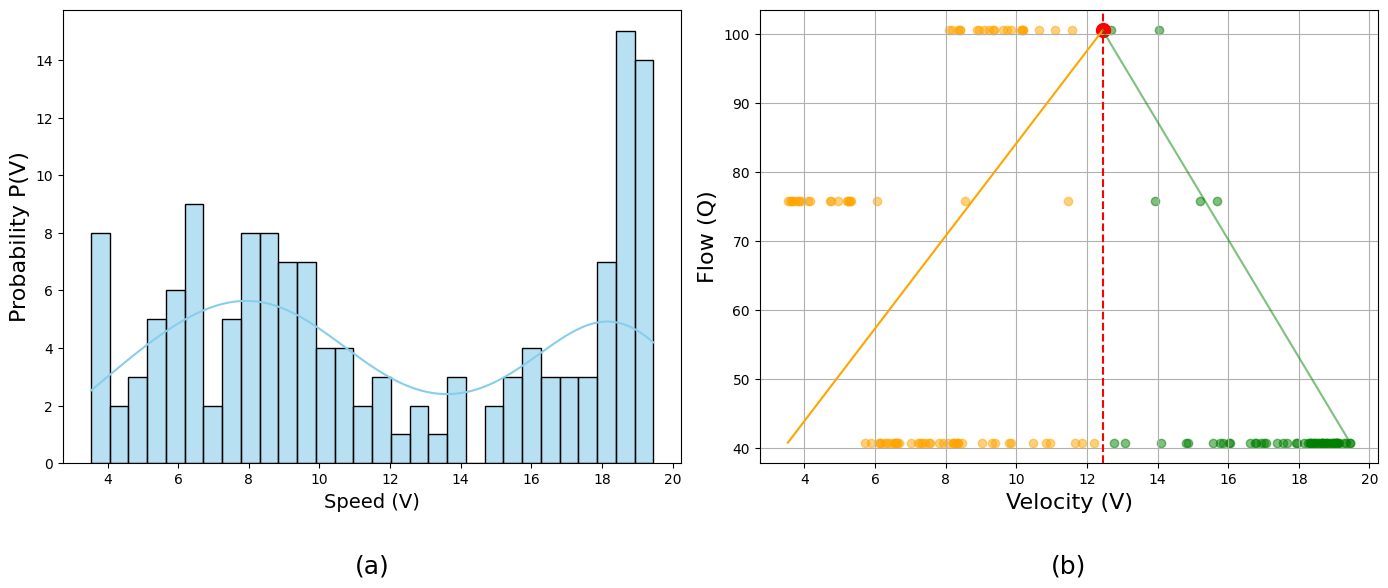

In [33]:
# plot_QV_1(level1_road_history_workday, 51584)
plot_QV_1(level1_road_history_workday, 31958, font_size=16)

In [ ]:
# # Plot the distribution of both Q and V

# plt.figure(figsize=(14, 6))

# # Distribution of Flow (Q)
# plt.subplot(1, 2, 1)
# sns.histplot(Q, bins=30, kde=True, color='blue', alpha=0.6)
# plt.title('Distribution of Flow (Q)')
# plt.xlabel('Flow (Q) [vehicles/hour]')
# plt.ylabel('Frequency')

# # Distribution of Velocity (V)
# plt.subplot(1, 2, 2)
# sns.histplot(V, bins=30, kde=True, color='green', alpha=0.6)
# plt.title('Distribution of Velocity (V)')
# plt.xlabel('Velocity (V) [km/h]')
# plt.ylabel('Frequency')

# # Show the plot
# plt.tight_layout()
# plt.show()

## Save file

In [ ]:
level1_road_history_workday.to_csv(file_path + 'level1_road_history_workday_QV.csv',index= False)
level2_road_history_workday.to_csv(file_path + 'level2_road_history_workday_QV.csv',index= False)
level3_road_history_workday.to_csv(file_path + 'level3_road_history_workday_QV.csv',index= False)

In [ ]:
level1_road_history_holiday.to_csv(file_path + 'level1_road_history_holiday_QV.csv',index= False)
level2_road_history_holiday.to_csv(file_path + 'level2_road_history_holiday_QV.csv',index= False)
level3_road_history_holiday.to_csv(file_path + 'level3_road_history_holiday_QV.csv',index= False)